<a href="https://colab.research.google.com/github/adityaharshsingh7/Face_mask_detection/blob/main/Face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow version: 2.19.0
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted successfully!
Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Model architecture created. Total parameters: 2422210
Compiling model...
Training model for 20 epochs...
Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 380s 989ms/step - accuracy: 0.8451 - loss: 0.3879 - val_accuracy: 0.9801 - val_loss: 0.0814
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 75s 197ms/step - accuracy: 0.9375 - loss: 0.1298 - val_accuracy: 0.9774 - val_loss: 0.0813
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9797 - loss: 0.0783 - val_accuracy: 0.9847 - val_loss: 0.0623
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 75s 197ms/step - accuracy: 0.8750 - loss: 0.2084 - val_accuracy: 0.9834 - val_loss: 0.0592
Epoch 5/

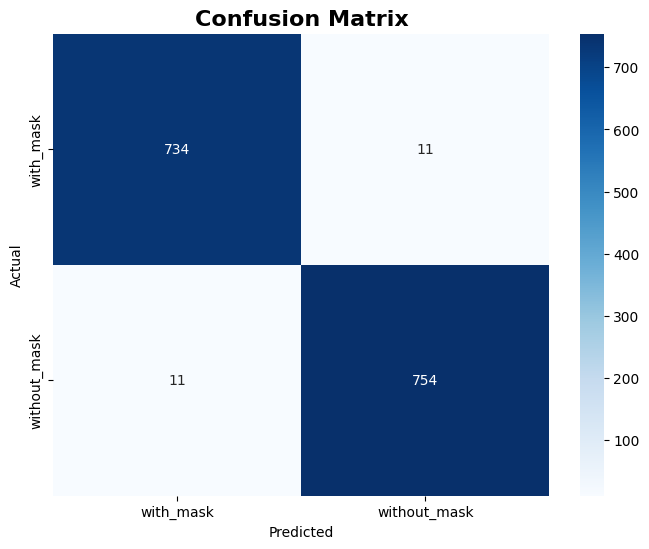

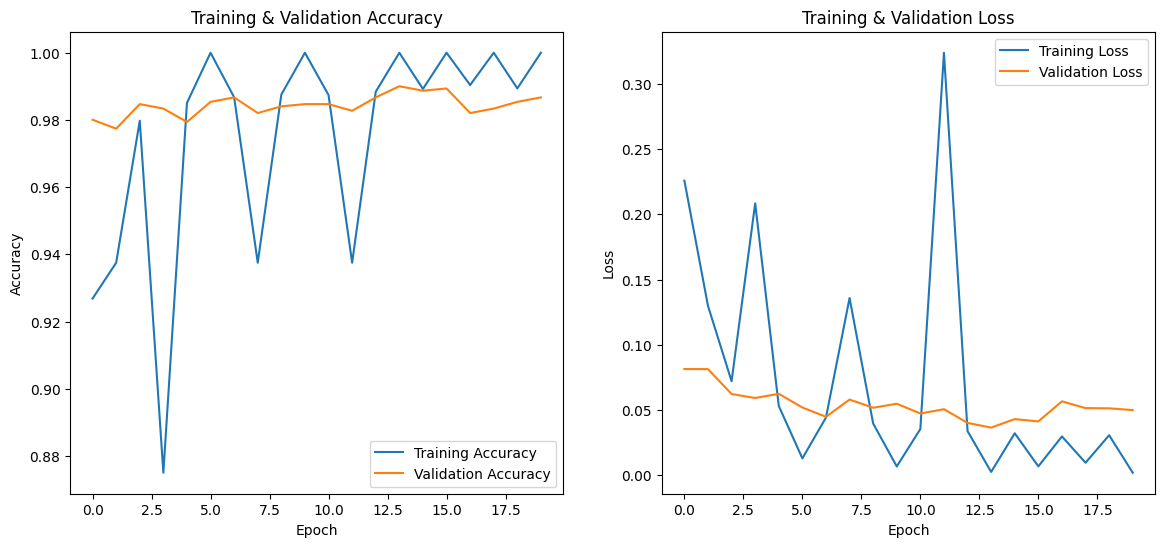

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=face_mask_detector.model.

In [2]:
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES

!pip install kaggle tensorflow opencv-python matplotlib seaborn scikit-learn imutils --quiet

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")


# STEP 2: SETUP KAGGLE API AND DOWNLOAD DATASET

from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset

import zipfile
with zipfile.ZipFile('face-mask-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("Dataset downloaded and extracted successfully!")

DATASET_PATH = "data"  # Adjust if needed based on extracted folder structure

# STEP 3: DATA GENERATORS FOR MEMORY EFFICIENT LOADING

# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% training data for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# STEP 4: MODEL ARCHITECTURE - MobileNetV2 base with custom head

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print(f"Model architecture created. Total parameters: {model.count_params()}")


# STEP 5: COMPILE AND TRAIN MODEL

INIT_LR = 1e-4
EPOCHS = 20

print("Compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print(f"Training model for {EPOCHS} epochs...")
H = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS
)

print("Model training completed!")


# STEP 6: EVALUATE MODEL PERFORMANCE

# Predict on validation data
val_steps = validation_generator.samples // validation_generator.batch_size + 1
predIdxs = model.predict(validation_generator, steps=val_steps)
predIdxs = np.argmax(predIdxs, axis=1)

print("Classification Report:")
print(classification_report(validation_generator.classes, predIdxs,
                            target_names=list(validation_generator.class_indices.keys())))

accuracy = accuracy_score(validation_generator.classes, predIdxs)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, predIdxs)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training accuracy and loss plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [3]:
# STEP 7: SAVE MODEL
model.save("face_mask_detector.h5")
print("Model saved as face_mask_detector.h5")

Model saved as face_mask_detector.h5


--2025-08-27 17:13:57--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-08-27 17:13:57 (62.3 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-08-27 17:13:57--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Saving face mask.jpg to face mask.jpg
Processing face mask.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Mask with confidence 100.00%
Prediction: Mask with confidence 100.00%


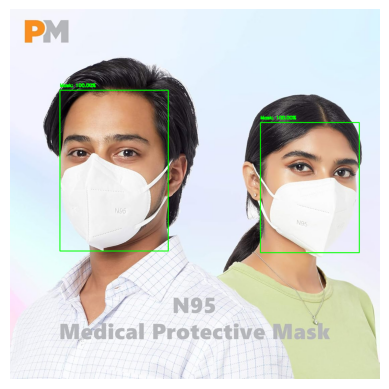

In [4]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

def detect_mask_on_image(image_path, faceNet, maskNet):
    # Load the image
    image = cv2.imread(image_path)
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Prepare blob and detect faces
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Correct bounding boxes
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w - 1, endX), min(h - 1, endY)

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    faces = np.array(faces, dtype="float32")
    preds = maskNet.predict(faces, batch_size=32)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        confidence = max(mask, withoutMask) * 100
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        print(f"Prediction: {label} with confidence {confidence:.2f}%")

        cv2.putText(image, f"{label}: {confidence:.2f}%",
                    (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                    color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

    # Show the image with bounding boxes and labels
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

# Ensure your face detector model files are downloaded and loaded
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# Upload an image for prediction
uploaded = files.upload()

for image_name in uploaded.keys():
    print(f"Processing {image_name}...")
    detect_mask_on_image(image_name, faceNet, model)


--2025-08-27 17:16:45--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-08-27 17:16:45 (117 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-08-27 17:16:46--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

Saving facemask 1.jpg to facemask 1.jpg
Processing facemask 1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: No Mask with confidence 97.50%


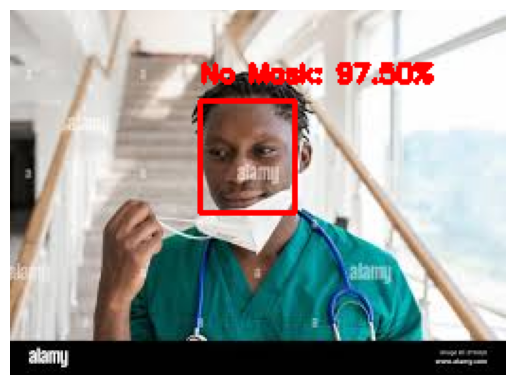

In [5]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

def detect_mask_on_image(image_path, faceNet, maskNet):
    # Load the image
    image = cv2.imread(image_path)
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Prepare blob and detect faces
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Correct bounding boxes
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w - 1, endX), min(h - 1, endY)

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    faces = np.array(faces, dtype="float32")
    preds = maskNet.predict(faces, batch_size=32)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        confidence = max(mask, withoutMask) * 100
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        print(f"Prediction: {label} with confidence {confidence:.2f}%")

        cv2.putText(image, f"{label}: {confidence:.2f}%",
                    (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                    color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

    # Show the image with bounding boxes and labels
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

# face detector model files are downloaded and loaded
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# Upload an image for prediction
uploaded = files.upload()

for image_name in uploaded.keys():
    print(f"Processing {image_name}...")
    detect_mask_on_image(image_name, faceNet, model)
